## import libary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

### Load CIFAR-10 dataset

In [2]:

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


### Define the classes of interest: airplane, bird, cat

In [3]:
classes_of_interest = [0, 2, 3]  # airplane: 0, bird: 2, cat: 3
class_names = {0: 'airplane', 2: 'bird', 3: 'cat'}

### Function to filter and limit dataset to 1000 samples per class

In [4]:
def filter_and_limit_data(X, Y, classes, limit_per_class):
    filtered_X = []
    filtered_Y = []
    for class_label in classes:
        class_indices = np.where(Y == class_label)[0][:limit_per_class]
        filtered_X.append(X[class_indices])
        filtered_Y.append(Y[class_indices])
    return np.vstack(filtered_X), np.vstack(filtered_Y)

### Filter and limit training data

In [5]:
X_train, Y_train = filter_and_limit_data(X_train, Y_train, classes_of_interest, 334)
X_test, Y_test = filter_and_limit_data(X_test, Y_test, classes_of_interest, 334)

### Adjust to exactly 1000 samples

In [6]:
X_train = X_train[:1000]
Y_train = Y_train[:1000]
X_test = X_test[:1000]
Y_test = Y_test[:1000]

print(X_train.shape)
print(X_test.shape)

(1000, 32, 32, 3)
(1000, 32, 32, 3)


### Preprocess images

In [7]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

### Function to plot images of a specific class

In [8]:
def plot_class_images(X, Y, class_label, class_name, num_images=10):
    class_indices = np.where(Y == class_label)[0]
    selected_indices = np.random.choice(class_indices, num_images, replace=False)
    selected_images = X[selected_indices]

    plt.figure(figsize=(15, 2))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Images of {class_name}')
    plt.show()


### Plot images of each class and flatten images

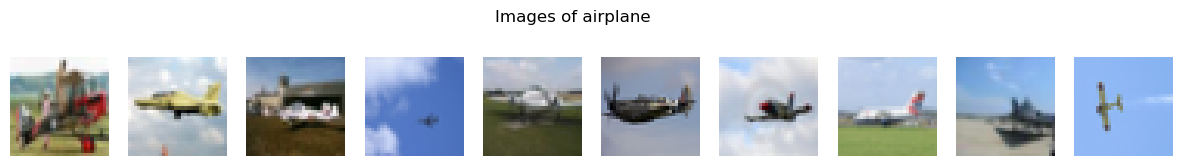

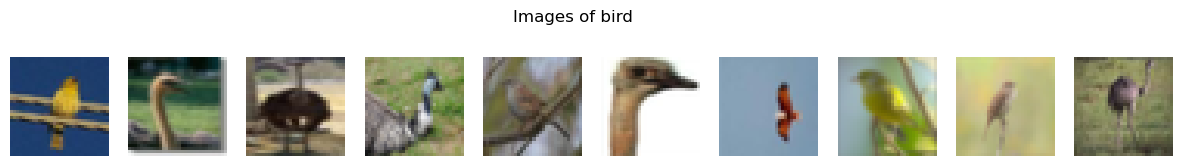

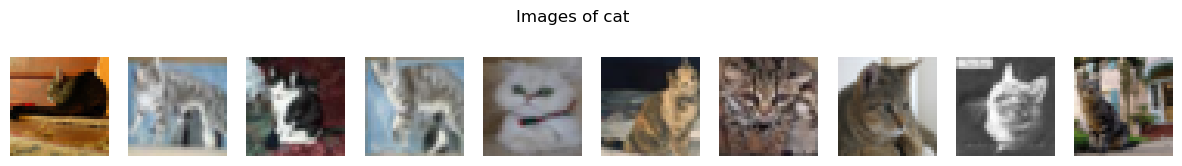

(1000, 3072)
(1000, 3072)


In [9]:
for class_label in classes_of_interest:
    plot_class_images(X_train.reshape(-1, 32, 32, 3), Y_train, class_label, class_names[class_label])

# Flatten images
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)
print(X_train.shape)  # should output (1000, 3072)
print(X_test.shape)   # should output (1000, 3072)


### SOM class

In [13]:
class SOM:
    def __init__(self, m, n, dim, learning_rate=0.5, radius=None, decay_function=None):
        self.m = m
        self.n = n
        self.dim = dim
        self.learning_rate = learning_rate
        self.radius = radius if radius else max(m, n) / 2
        self.decay_function = decay_function if decay_function else self._default_decay
        self.weights = np.random.random((m, n, dim))
        self.initial_radius = self.radius

    def _default_decay(self, learning_rate, radius, i, max_iter):
        return learning_rate * np.exp(-i / max_iter), radius * np.exp(-i / max_iter)

    def _find_bmu(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=2)
        bmu_idx = np.unravel_index(np.argmin(distances), (self.m, self.n))
        return bmu_idx

    def _update_weights(self, sample, bmu_idx, learning_rate, radius):
        for i in range(self.m):
            for j in range(self.n):
                weight = self.weights[i, j, :]
                dist_to_bmu = np.linalg.norm(np.array([i, j]) - np.array(bmu_idx))
                if dist_to_bmu < radius:
                    influence = np.exp(-(dist_to_bmu**2) / (2 * (radius**2)))
                    self.weights[i, j, :] += influence * learning_rate * (sample - weight)

    def train(self, data, num_iterations):
        for i in range(num_iterations):
            for sample in data:
                bmu_idx = self._find_bmu(sample)
                learning_rate, radius = self.decay_function(self.learning_rate, self.initial_radius, i, num_iterations)
                self._update_weights(sample, bmu_idx, learning_rate, radius)
            if i % 10 == 0:
                print(f"Iteration {i+10}/{num_iterations} complete")

    def map_vects(self, data):
        bmu_indices = np.array([self._find_bmu(sample) for sample in data])
        return bmu_indices

### Define SOM dimensions and parameters

In [14]:
som = SOM(m=16, n=16, dim=32*32*3, learning_rate=0.5, radius=3)

### Test 1 

In [15]:
som = SOM(m=32, n=32, dim=32*32*3, learning_rate=0.5, radius=0)

### Train SOM

In [17]:
som.train(X_train, num_iterations=80)
print("job done")

Iteration 10/80 complete
Iteration 20/80 complete
Iteration 30/80 complete
Iteration 40/80 complete
Iteration 50/80 complete
Iteration 60/80 complete
Iteration 70/80 complete
Iteration 80/80 complete
job done


### Map training and testing data to BMU indices

In [18]:
train_bmu_indices = som.map_vects(X_train)
test_bmu_indices = som.map_vects(X_test)

print("Training data mapped to BMU indices")
print(train_bmu_indices)
print("Testing data mapped to BMU indices")
print(test_bmu_indices)

Training data mapped to BMU indices
[[27  0]
 [11 13]
 [27 11]
 ...
 [22 21]
 [ 5 12]
 [ 0 20]]
Testing data mapped to BMU indices
[[22  4]
 [10 11]
 [ 0  0]
 ...
 [10  0]
 [16 12]
 [ 6 18]]


### Define the get_cluster_counts function

In [19]:
def get_cluster_counts(som, data):
    bmu_indices = som.map_vects(data)
    unique_bmus, counts = np.unique(bmu_indices, axis=0, return_counts=True)
    return counts

In [20]:
train_cluster_counts = get_cluster_counts(som, X_train)
test_cluster_counts = get_cluster_counts(som, X_test)

### Print cluster counts with commas

In [21]:
print("Training Data Cluster Counts:", ", ".join(map(str, train_cluster_counts)))
print("Testing Data Cluster Counts:", ", ".join(map(str, test_cluster_counts)))

Training Data Cluster Counts: 38, 2, 1, 3, 11, 7, 9, 2, 24, 5, 4, 3, 6, 1, 1, 1, 2, 6, 7, 10, 2, 3, 13, 5, 8, 6, 2, 2, 3, 12, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 5, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 4, 3, 2, 2, 1, 3, 4, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 4, 3, 5, 2, 1, 2, 2, 1, 3, 5, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 11, 4, 4, 2, 4, 2, 1, 1, 1, 1, 3, 5, 7, 3, 2, 1, 1, 2, 2, 1, 1, 5, 1, 12, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 9, 5, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 3, 2, 1, 3, 3, 2, 1, 2, 2, 2, 1, 1, 4, 1, 2, 1, 2, 4, 1, 1, 1, 5, 1, 1, 1, 1, 5, 5, 2, 1, 1, 4, 1, 2, 1, 1, 1, 1, 3, 1, 1, 2, 2, 2, 9, 10, 2, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1, 3, 9, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 7, 3, 2, 2, 7, 2

In [22]:
def plot_som_clusters(som, data, title):
    cluster_info = []
    plt.figure(figsize=(10, 10))
    for x in range(som.m):
        for y in range(som.n):
            plt.text(x, y, '', ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.5, lw=0))
    
    bmu_indices = som.map_vects(data)
    unique_bmus = np.unique(bmu_indices, axis=0)
    
    for bmu in unique_bmus:
        points = data[(bmu_indices == bmu).all(axis=1)]
        cluster_info.append(f"{bmu[0]},{bmu[1]}:{len(points)}")
        plt.text(bmu[1], bmu[0], str(len(points)),
                 ha='center', va='center',
                 bbox=dict(facecolor='red', alpha=0.5, lw=0))
    
    plt.title(title)
    plt.xlim(-0.5, som.n-0.5)
    plt.ylim(-0.5, som.m-0.5)
    plt.gca().invert_yaxis()
    plt.show()
    
    return cluster_info

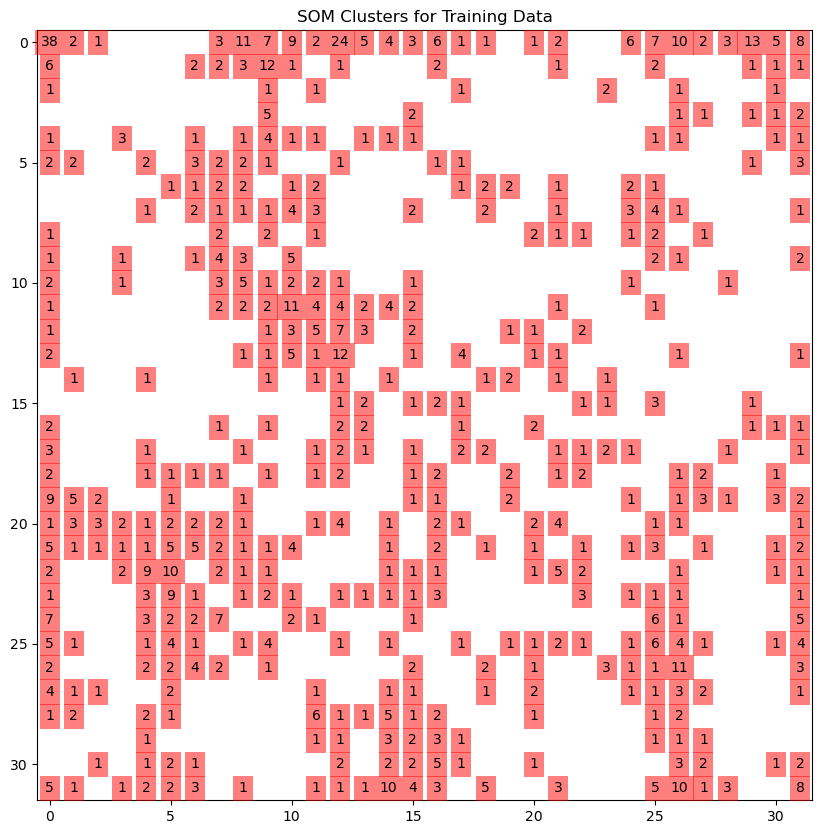

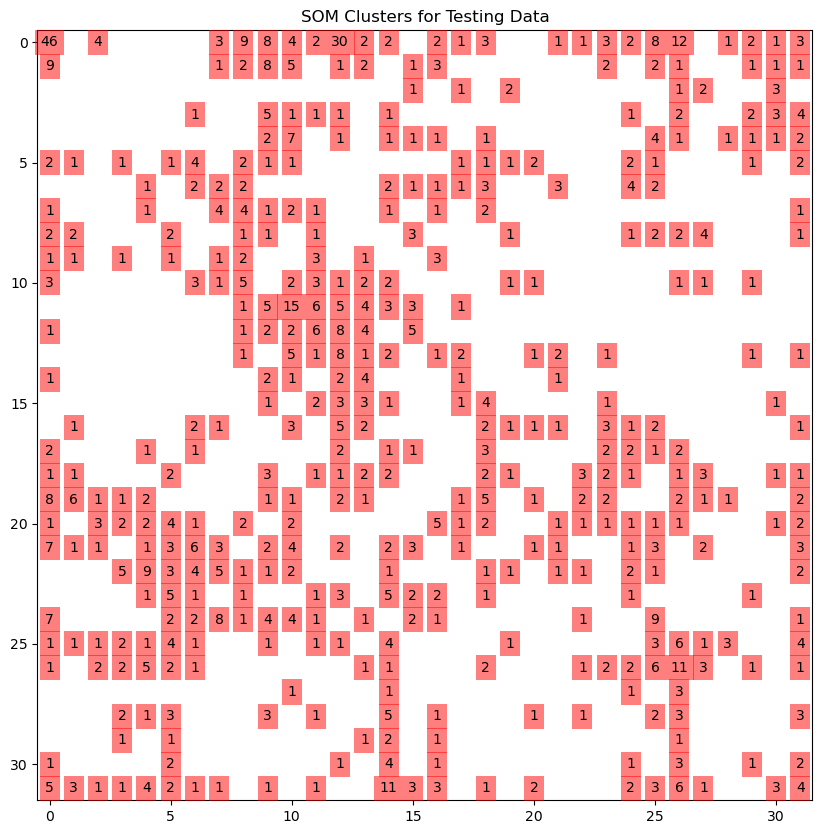

In [23]:
train_clusters = plot_som_clusters(som, X_train, "SOM Clusters for Training Data")
test_clusters = plot_som_clusters(som, X_test, "SOM Clusters for Testing Data")

In [24]:
def calculate_accuracy(labels, bmu_indices):
    cluster_labels = {}
    for idx, bmu in enumerate(bmu_indices):
        bmu_tuple = tuple(bmu)
        if bmu_tuple not in cluster_labels:
            cluster_labels[bmu_tuple] = []
        cluster_labels[bmu_tuple].append(labels[idx])
    
    correct_predictions = 0
    total_predictions = len(labels)
    
    for bmu, label_list in cluster_labels.items():
        most_common_label = np.bincount(np.array(label_list).flatten()).argmax()
        correct_predictions += (np.array(label_list).flatten() == most_common_label).sum()
    
    accuracy = correct_predictions / total_predictions
    return accuracy

In [25]:
train_accuracy = calculate_accuracy(Y_train, train_bmu_indices)
test_accuracy = calculate_accuracy(Y_test, test_bmu_indices)

In [26]:
print(f"Training data accuracy: {train_accuracy}")
print(f"Testing data accuracy: {test_accuracy}")

Training data accuracy: 0.759
Testing data accuracy: 0.739
